## Carvana Cars Model Building

In [311]:
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

import statsmodels.api as sm

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestRegressor #mainly for the potentially sparcity of some features.
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet #linear for baseline, Ridge and Lasso for regularization effect quantifiers
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import lightgbm as lgb
import optuna


import warnings
warnings.filterwarnings('ignore')

In [312]:
carvana_df = pd.read_csv("carvana_postprocessed.csv")
carvana_df.drop(columns=['Unnamed: 0'], inplace=True)

In [313]:
carvana_df.head()

,make,year,mileage,state,mpgCity,mpgHighway,engineCylinderCount,fuel,driveTrain,exteriorColor,interiorColor,numberOfKeys,doors,seating,AC,PowerWindows,CDPlayer,PowerLocks,TiltWheel,PowerSeats,imperfections,EngineDesc_Transformed,Transmission_Transformed,Bluetooth,Rear View Camera,price
0,30,2017.0,47569.0,6,17.0,25.0,6.0,2,0,6,3,2.0,4.0,6.0,1,1,0,1,1,1,1.386294,5,0,0,1,10.373210
1,5,2015.0,42722.0,17,21.0,33.0,4.0,3,6,12,3,2.0,4.0,5.0,1,1,0,1,1,1,1.791759,1,0,1,1,10.025307
2,4,2016.0,48730.0,8,19.0,27.0,4.0,3,3,14,1,2.0,4.0,5.0,1,1,1,1,1,1,1.609438,1,0,1,1,9.903037
3,34,2011.0,95381.0,0,21.0,27.0,4.0,3,4,14,3,2.0,4.0,5.0,1,1,1,1,1,1,1.386294,1,0,0,1,9.679781
4,14,2017.0,65084.0,21,24.0,32.0,4.0,3,4,11,1,1.0,4.0,5.0,1,1,1,1,1,0,1.609438,1,0,1,0,9.716616


Since Robust Scaler is robust to outliers (hence the name), we can apply Robust Scaler for model building. I may not apply Optuna like I have in previous projects in order to get experience with different model building techniques.

I'll first start by applying statsmodels OLS method.

### Regression Assumptions Check
Before jumping right in, let's check that our data passes on the regression task assumptions, and make changes where necessary. Let's first check for <b>multicollinearity</b> with a correlation matrix below:

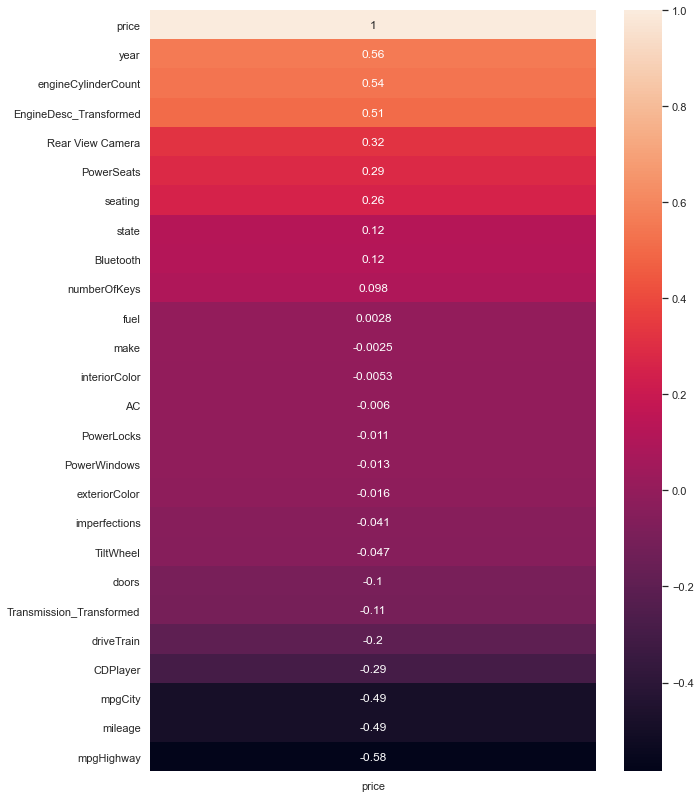

In [314]:
plt.figure(figsize=(10, 14)) 
heatmap = sns.heatmap(carvana_df.corr()[['price']].sort_values(by='price', ascending=False), annot=True)

As observed before, some attributes are positively correlated, while some are negatively correlated.

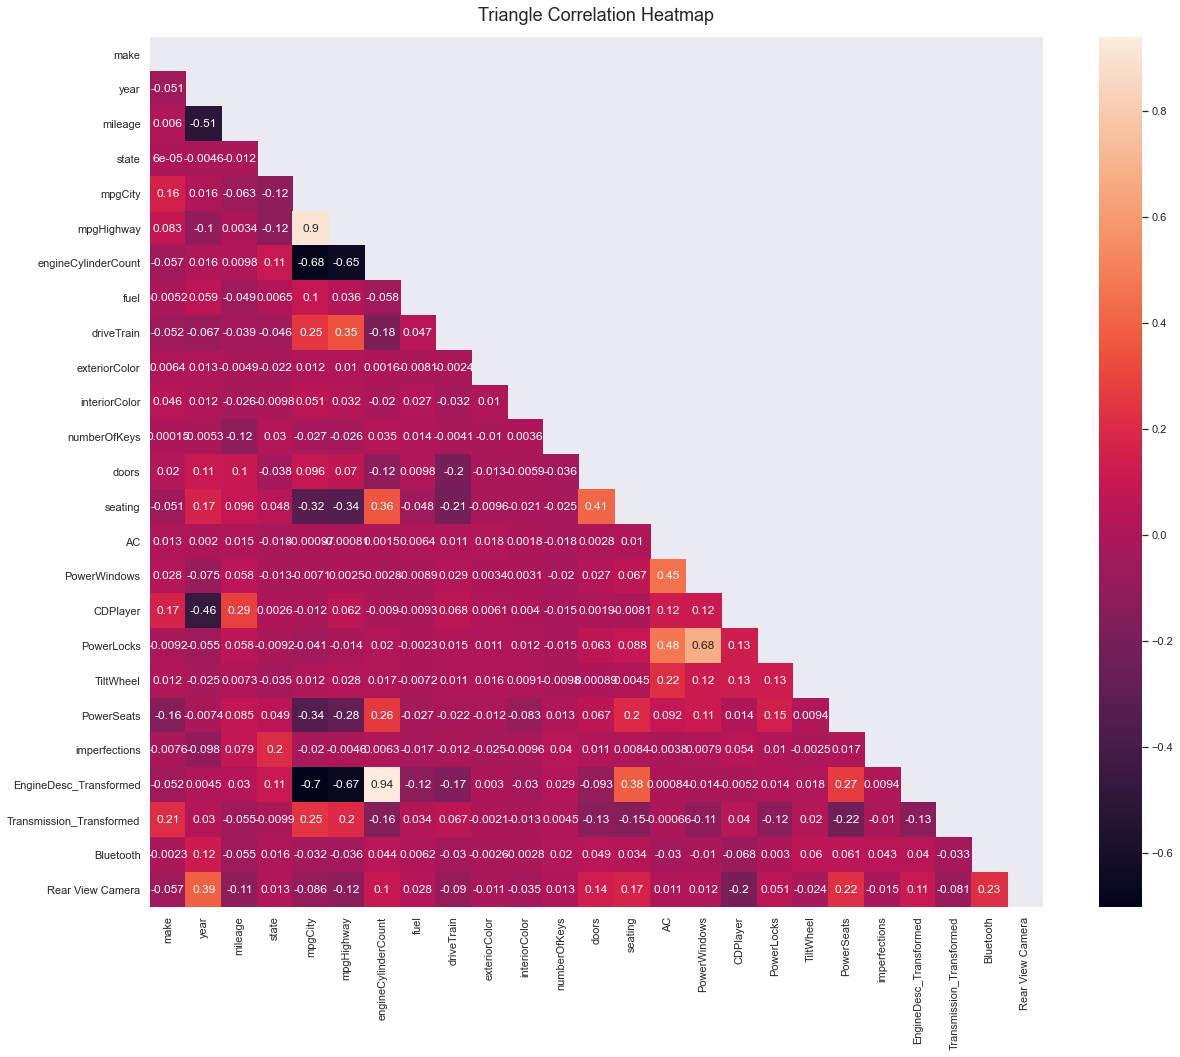

In [315]:
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(carvana_df.loc[:, :'Rear View Camera'].corr(), dtype=np.bool))
heatmap = sns.heatmap(carvana_df.loc[:, :'Rear View Camera'].corr(), annot=True, mask=mask)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

As noted before, mpgCity and mpgHighway are very correlated with each other, as well as engineCylinderCount and the Engine Description. PowerWindows and PowerLocks also have strong correlation. We'll keep these attributes in mind.

Let's also create some plots to check <b>normality</b> and <b>autocorrelation</b>.

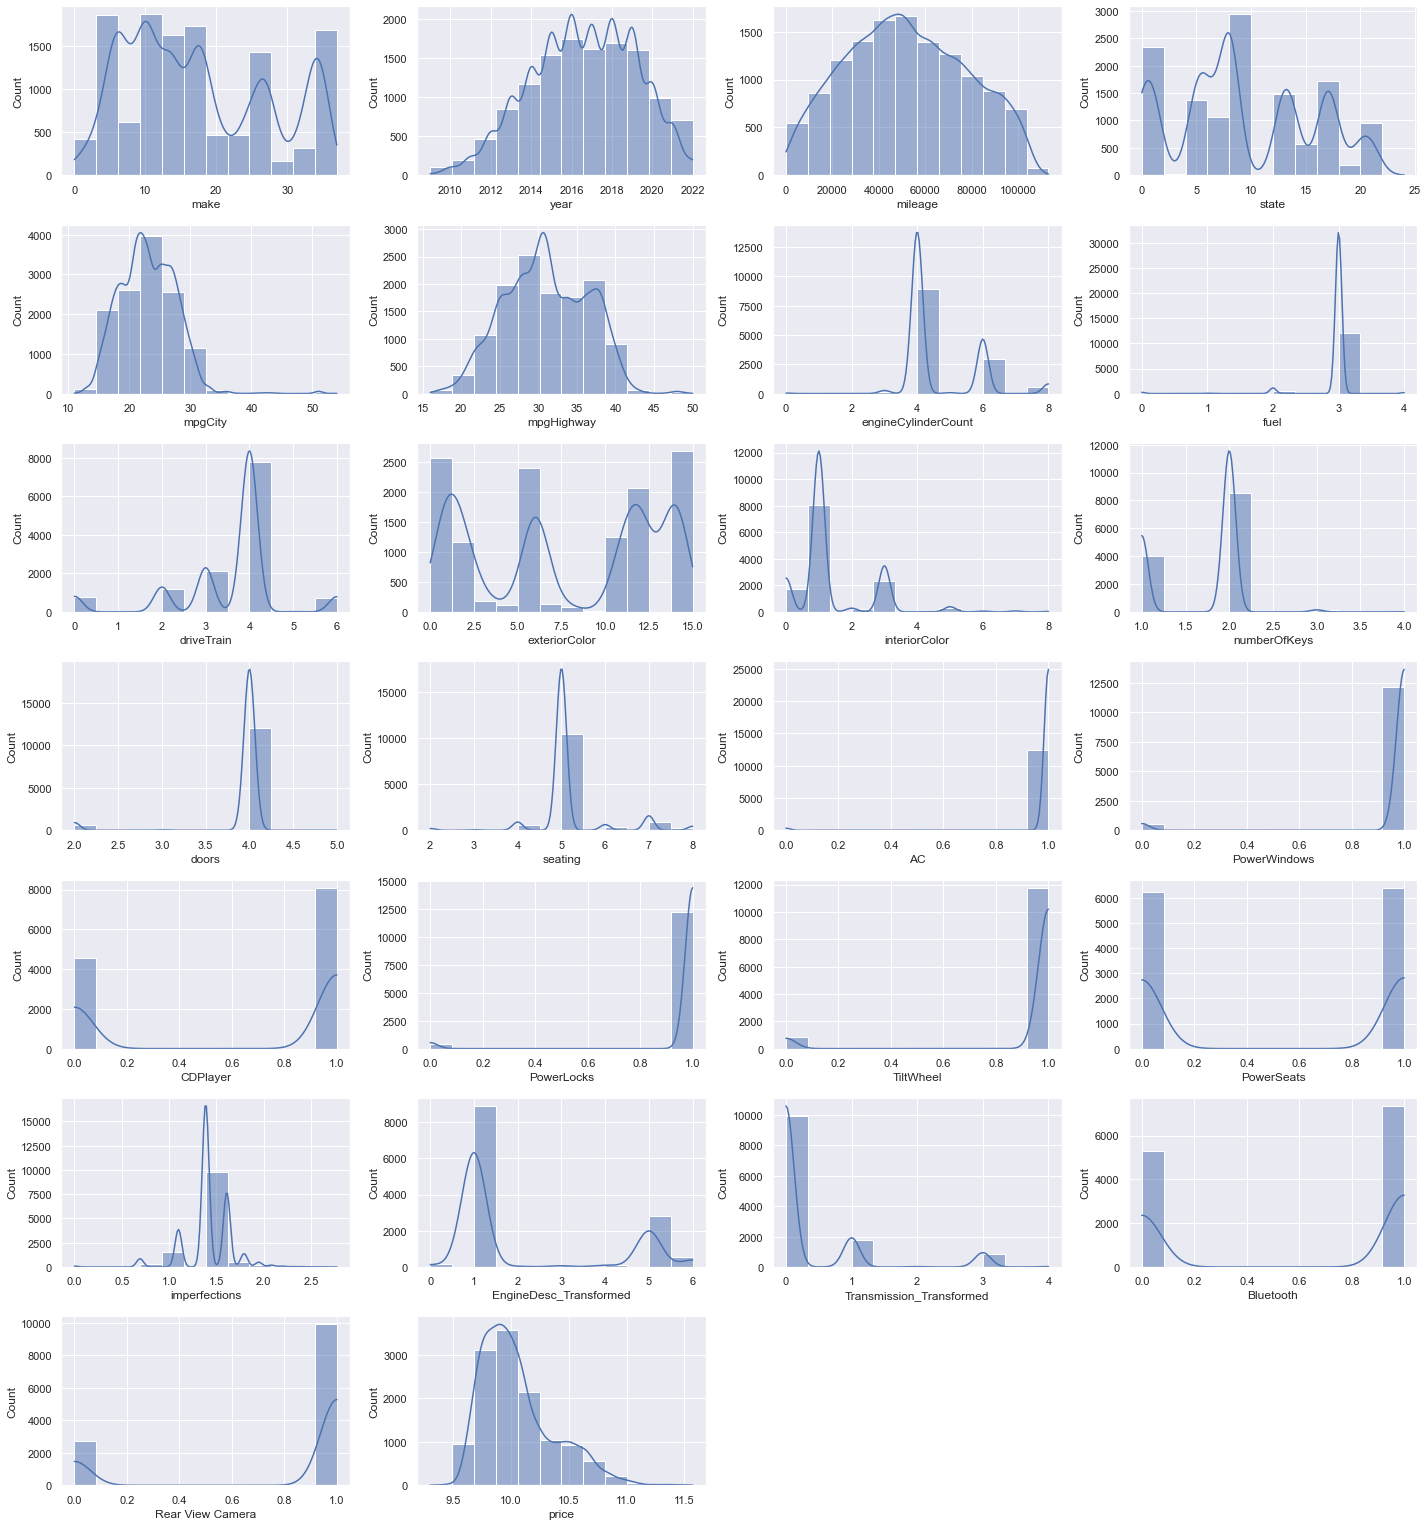

In [316]:
i = 1
plt.figure(figsize=(20,30))

#Checking for normality among the attributes (mainly concerning the continuous attributes)
for col in carvana_df.columns.tolist():
    plt.subplot(10,4,i)
    sns.histplot(x=col, data=carvana_df, bins=12, kde=True)
    i = i + 1
    plt.tight_layout()

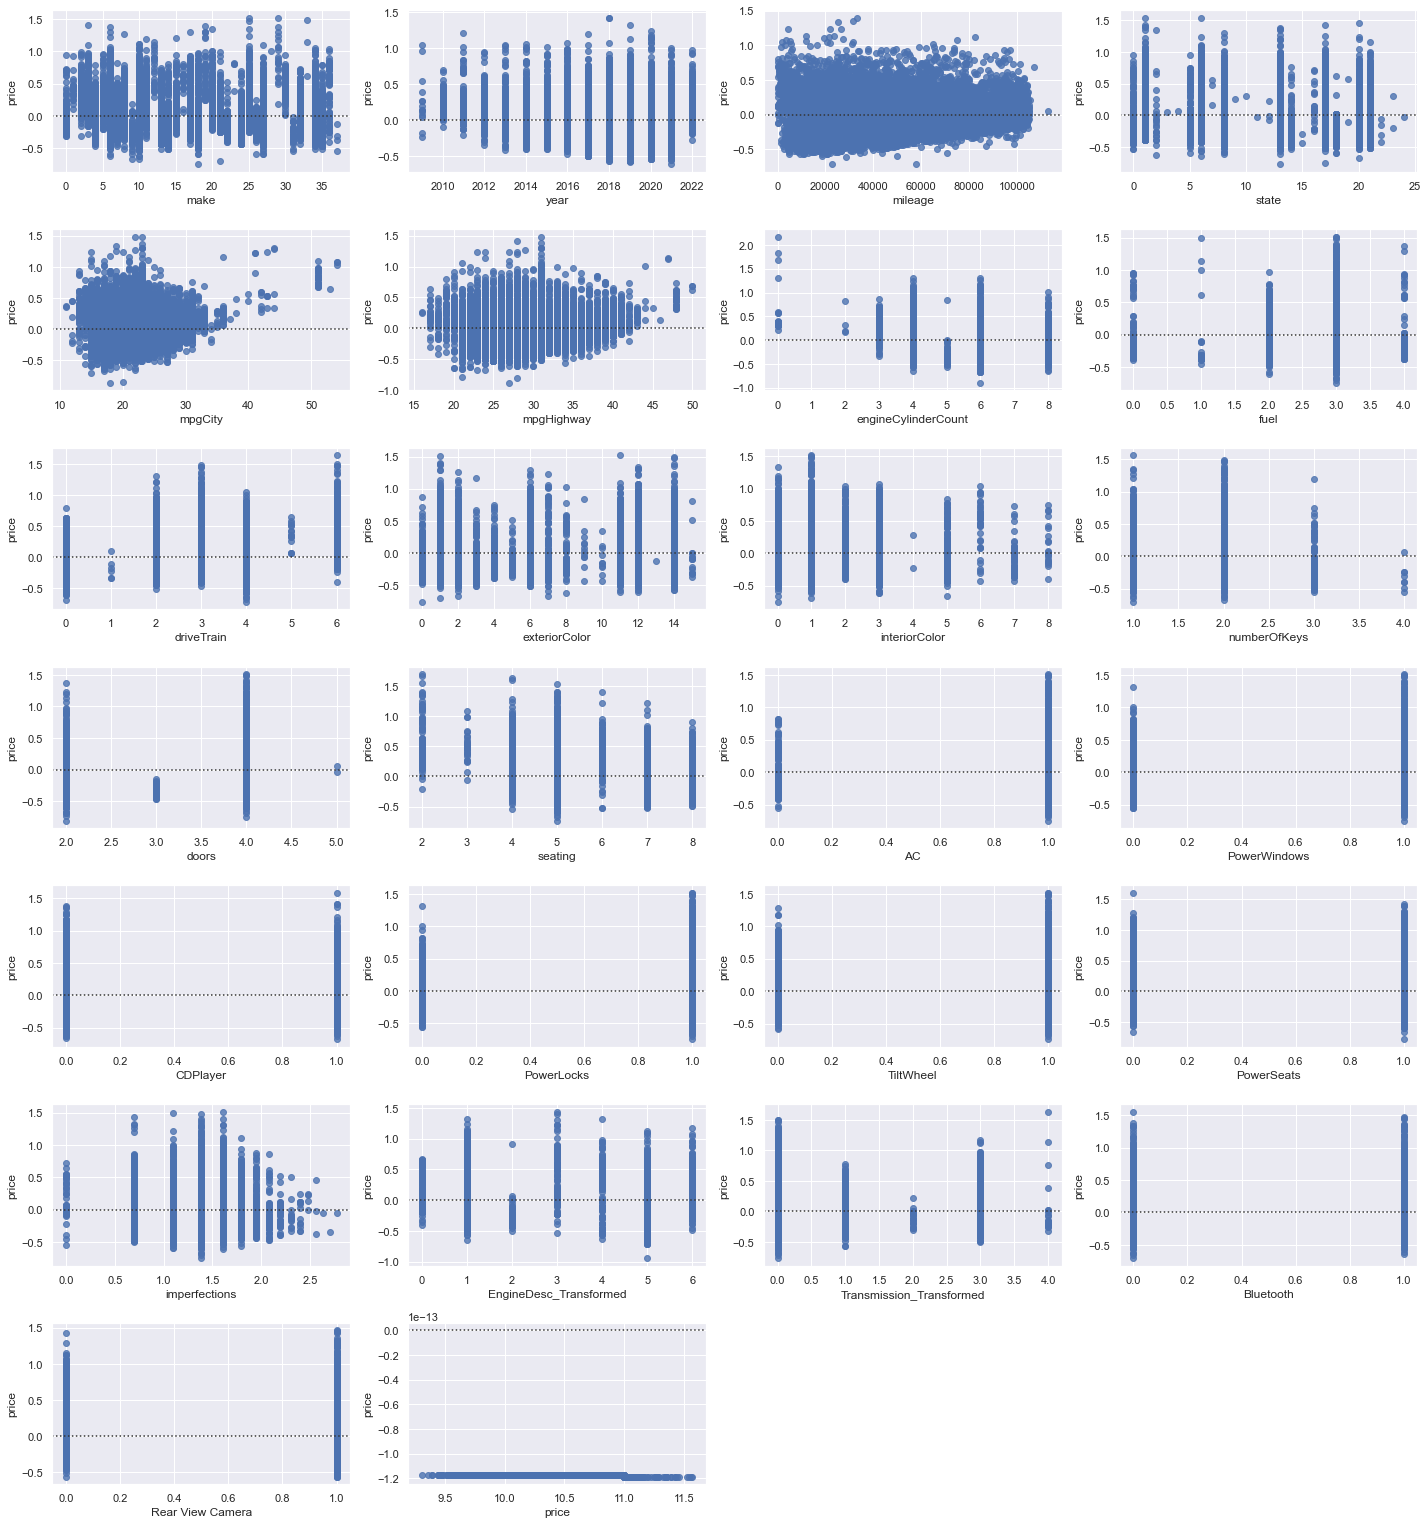

In [317]:
i = 1
plt.figure(figsize=(20,30))

#Residual plots to observe errors and ensure no autocorrelation as well as another check for homoskedasticity
for col in carvana_df.columns.tolist():
    plt.subplot(10,4,i)
    sns.residplot(x=col, y='price', data=carvana_df)
    i = i + 1
    plt.tight_layout()

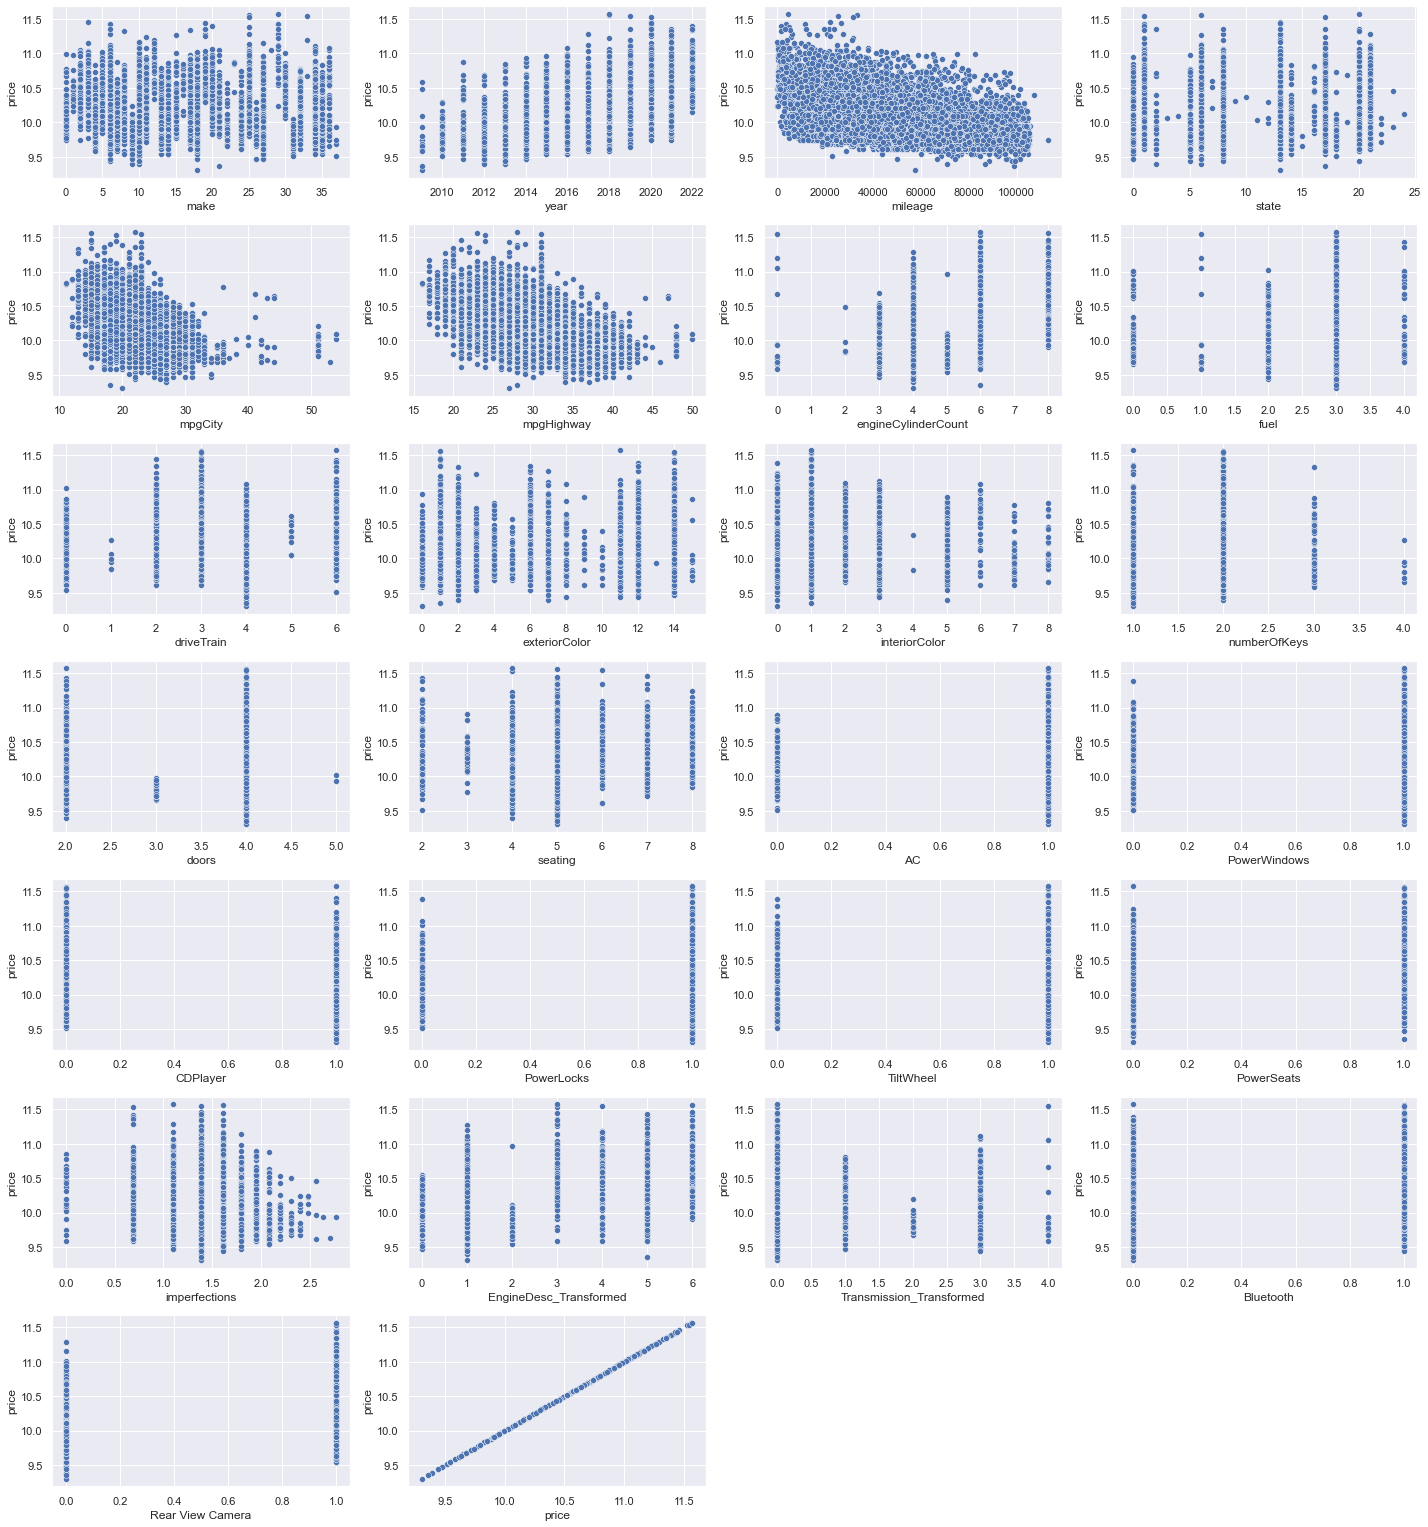

In [318]:
i = 1
plt.figure(figsize=(20,30))

#Residual plots to observe errors and ensure no autocorrelation.
for col in carvana_df.columns.tolist():
    plt.subplot(10,4,i)
    sns.scatterplot(x=col, y='price', data=carvana_df)
    i = i + 1
    plt.tight_layout()

Analying our continuous variables, we point out the attributes showing correlation with price whether positive or negative. We can see some attributes exhibit some <b>heteroskedasticity</b>, but we will leave these attributes be since we have various attributes we are working with and chose to leave potential outliers be.

Let's check for <b>positive variance</b> among the independent variables below as well:

In [319]:
#outliers appear to be primarily prevalent in mpgCity, but we drop this column

In [320]:

for col in carvana_df.columns.tolist()[:-1]:
    print(f"Variance for {col} is: {np.var(carvana_df[col])}")

Variance for make is: 99.88603402133
Variance for year is: 6.599221398087296
Variance for mileage is: 669116246.598842
Variance for state is: 38.841087168492884
Variance for mpgCity is: 20.47476312079574
Variance for mpgHighway is: 28.463782250424146
Variance for engineCylinderCount is: 1.2758892820852803
Variance for fuel is: 0.10739187571347666
Variance for driveTrain is: 1.5092051791069494
Variance for exteriorColor is: 25.866628343369506
Variance for interiorColor is: 1.371074846884524
Variance for numberOfKeys is: 0.23450592262718978
Variance for doors is: 0.17480496136796644
Variance for seating is: 0.6078255160127157
Variance for AC is: 0.01211133916110596
Variance for PowerWindows is: 0.0381350013333709
Variance for CDPlayer is: 0.23038316227411998
Variance for PowerLocks is: 0.03469842065841197
Variance for TiltWheel is: 0.06429157139271387
Variance for PowerSeats is: 0.24994411429241864
Variance for imperfections is: 0.059229656882207306
Variance for EngineDesc_Transformed is

Some values are quite small, particularly the categorical variables, but we do not have any negative variance.

Assumption Check Notes:
* <i>mpgCity and mpgHighway, engineCylinderCount and EngineDesc, PowerWindows and PowerLocks</i> are collinear, therefore as we build models, we must deal with these attributes. 

In [407]:
carvana_df.head()

,make,year,mileage,state,mpgCity,mpgHighway,engineCylinderCount,fuel,driveTrain,exteriorColor,interiorColor,numberOfKeys,doors,seating,AC,PowerWindows,CDPlayer,PowerLocks,TiltWheel,PowerSeats,imperfections,EngineDesc_Transformed,Transmission_Transformed,Bluetooth,Rear View Camera,price
0,30,2017.0,47569.0,6,17.0,25.0,6.0,2,0,6,3,2.0,4.0,6.0,1,1,0,1,1,1,1.386294,5,0,0,1,10.373210
1,5,2015.0,42722.0,17,21.0,33.0,4.0,3,6,12,3,2.0,4.0,5.0,1,1,0,1,1,1,1.791759,1,0,1,1,10.025307
2,4,2016.0,48730.0,8,19.0,27.0,4.0,3,3,14,1,2.0,4.0,5.0,1,1,1,1,1,1,1.609438,1,0,1,1,9.903037
3,34,2011.0,95381.0,0,21.0,27.0,4.0,3,4,14,3,2.0,4.0,5.0,1,1,1,1,1,1,1.386294,1,0,0,1,9.679781
4,14,2017.0,65084.0,21,24.0,32.0,4.0,3,4,11,1,1.0,4.0,5.0,1,1,1,1,1,0,1.609438,1,0,1,0,9.716616


In [408]:
cat_cols = ['make', 'state', 'fuel', 'driveTrain', 'exteriorColor', 'interiorColor', 'AC', 'PowerWindows', 'CDPlayer', 'PowerLocks', 'TiltWheel', 'PowerSeats', 'EngineDesc_Transformed', 'Transmission_Transformed']
for col in cat_cols:
    carvana_df[col] = pd.Categorical(carvana_df[col])

### OLS Regression Model (statsmodels)
Below, I will begin using the statsmodels OLS regression model. I will start model building with no alterations to the data, then I will make changes based on returned p-values and the observations made above.

In [409]:
x_original = carvana_df.loc[:, :'Rear View Camera']

In [410]:
x_nocollinear = carvana_df.loc[:, :'Rear View Camera']
x_nocollinear.drop(columns=['EngineDesc_Transformed', 'PowerLocks', 'mpgCity'], inplace=True)


In [411]:
x1 = carvana_df.loc[:, :'Rear View Camera']
y = carvana_df.loc[:, 'price']

In [412]:
#Using the scaler gives the same results. there is no difference.
rb_scaler = RobustScaler()
x1_scaled = rb_scaler.fit_transform(x1)

In [413]:
X = sm.add_constant(x1)

In [414]:
model = sm.OLS(y, X)

In [415]:
results = model.fit()

In [416]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1623.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:27:36   Log-Likelihood:                 5779.0
No. Observations:               12641   AIC:                        -1.151e+04
Df Residuals:                   12615   BIC:                        -1.131e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -71.0173      1.535    -46.259      0.000     -74.026     -68.008
make                         0.0027      0.000     18.068      0.000       0.002       0.003
year                         0.0404      0.001     53.082      0.000       0.039       0.042
mileage                  -3.732e-06   6.43e-08    -58.002      0.000   -3.86e-06   -3.61e-06
state                        0.0019      0.000      8.532      0.000       0.001       0.002
mpgCity                      0.0068      0.001      8.295      0.000       0.005       0.008
mpgHighway                  -0.0222      0.001    -33.256      0.000      -0.024      -0.021
engineCylinderCount          0.0869      0.004     23.655      0.000       0.080       0.094
fuel                        -0.0075      0.004     -1.738      0.082      -0.016       0.001
driveTrain                  -0.0071      0.001     -5.665      0.000      -0.010      -0.005
exteriorColor               -0.0010      0.000     -3.710      0.000      -0.002      -0.000
interiorColor                0.0018      0.001      1.516      0.130      -0.001       0.004
numberOfKeys                 0.0256      0.003      8.989      0.000       0.020       0.031
doors                       -0.0683      0.004    -17.255      0.000      -0.076      -0.061
seating                      0.0095      0.002      4.225      0.000       0.005       0.014
AC                          -0.0488      0.015     -3.309      0.001      -0.078      -0.020
PowerWindows                 0.0575      0.010      5.857      0.000       0.038       0.077
CDPlayer                    -0.0157      0.003     -4.690      0.000      -0.022      -0.009
PowerLocks                  -0.0247      0.010     -2.355      0.019      -0.045      -0.004
TiltWheel                   -0.0341      0.006     -6.109      0.000      -0.045      -0.023
PowerSeats                   0.1025      0.003     33.237      0.000       0.096       0.109
imperfections                0.0054      0.006      0.930      0.352      -0.006       0.017
EngineDesc_Transformed      -0.0059      0.002     -2.553      0.011      -0.010      -0.001
Transmission_Transformed    -0.0057      0.002     -3.114      0.002      -0.009      -0.002
Bluetooth                    0.0099      0.003      3.462      0.001       0.004       0.016
Rear View Camera             0.0452      0.004     11.804      0.000       0.038       0.053
==============================================================================
Omnibus:                     2624.581   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8554.407
Skew:                           1.049   Prob(JB):                         0.00
Kurtosis:                       6.441   Cond. No.                     

Our baseline model without eliminating any attributes with insignifiance (higher than 0.05 p-values) isn't bad. We have a F-stat p-value of virtually zero and a pretty high F-statistic. We can keep track of these metrics as we try different models with insignificant attributes removed.

Also, using the Durbin-Watson test, we have a value between 1.5 and 2.5 (1.948), indicating evidence against having autocorrelation within our data.

Admittedly to my surprise, the <i>imperfections</i> appear to be the most insignificant attribute to this model, followed by <i>interiorColor</i> and <i>fuel</i>. Would this imply that despite how many small dents and scratches a car has that it does not affect the price of a car being sold in any way? Perhaps not, but it is fun to entertain the thought.

In [417]:
#Dropping attributes with p-values > 0.05:
x1.drop(columns=['fuel', 'interiorColor', 'imperfections'], inplace=True)

In [418]:
X = sm.add_constant(x1)
model = sm.OLS(y, X)

In [419]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1844.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:27:51   Log-Likelihood:                 5775.9
No. Observations:               12641   AIC:                        -1.151e+04
Df Residuals:                   12618   BIC:                        -1.133e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -70.9558      1.532    -46.308      0.000     -73.959     -67.952
make                         0.0027      0.000     18.186      0.000       0.002       0.003
year                         0.0404      0.001     53.123      0.000       0.039       0.042
mileage                   -3.73e-06   6.43e-08    -58.010      0.000   -3.86e-06    -3.6e-06
state                        0.0020      0.000      8.873      0.000       0.002       0.002
mpgCity                      0.0066      0.001      8.179      0.000       0.005       0.008
mpgHighway                  -0.0221      0.001    -33.372      0.000      -0.023      -0.021
engineCylinderCount          0.0859      0.004     23.732      0.000       0.079       0.093
driveTrain                  -0.0073      0.001     -5.876      0.000      -0.010      -0.005
exteriorColor               -0.0010      0.000     -3.705      0.000      -0.002      -0.000
numberOfKeys                 0.0257      0.003      9.018      0.000       0.020       0.031
doors                       -0.0685      0.004    -17.322      0.000      -0.076      -0.061
seating                      0.0096      0.002      4.261      0.000       0.005       0.014
AC                          -0.0490      0.015     -3.322      0.001      -0.078      -0.020
PowerWindows                 0.0577      0.010      5.877      0.000       0.038       0.077
CDPlayer                    -0.0158      0.003     -4.719      0.000      -0.022      -0.009
PowerLocks                  -0.0245      0.010     -2.341      0.019      -0.045      -0.004
TiltWheel                   -0.0340      0.006     -6.094      0.000      -0.045      -0.023
PowerSeats                   0.1022      0.003     33.187      0.000       0.096       0.108
EngineDesc_Transformed      -0.0052      0.002     -2.288      0.022      -0.010      -0.001
Transmission_Transformed    -0.0059      0.002     -3.241      0.001      -0.009      -0.002
Bluetooth                    0.0100      0.003      3.517      0.000       0.004       0.016
Rear View Camera             0.0448      0.004     11.729      0.000       0.037       0.052
==============================================================================
Omnibus:                     2641.485   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8663.923
Skew:                           1.053   Prob(JB):                         0.00
Kurtosis:                       6.466   Cond. No.                     6.53e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.53e+07. This might indicate that there are
strong mult

We have a model here where all attributes used are significant, we also see an increase in the F-statistic. The R2 score did not change. Let's now drop the attributes we found to be multicollinear, I will choose the attributes to drop based on the higher p-values from above. Therefore, I will drop <i>EngineDesc, PowerLocks, & mpgCity</i>. (mpgCity had a lower MI score)

In [420]:
x1.drop(columns=['EngineDesc_Transformed', 'PowerLocks', 'mpgCity'], inplace=True)

In [421]:
X = sm.add_constant(x1)
model = sm.OLS(y, X)

In [422]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     2117.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:28:12   Log-Likelihood:                 5734.0
No. Observations:               12641   AIC:                        -1.143e+04
Df Residuals:                   12621   BIC:                        -1.128e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -73.0658      1.518    -48.121      0.000     -76.042     -70.090
make                         0.0029      0.000     20.118      0.000       0.003       0.003
year                         0.0415      0.001     55.070      0.000       0.040       0.043
mileage                  -3.745e-06   6.45e-08    -58.066      0.000   -3.87e-06   -3.62e-06
state                        0.0019      0.000      8.772      0.000       0.002       0.002
mpgHighway                  -0.0174      0.000    -47.031      0.000      -0.018      -0.017
engineCylinderCount          0.0749      0.002     44.295      0.000       0.072       0.078
driveTrain                  -0.0086      0.001     -6.940      0.000      -0.011      -0.006
exteriorColor               -0.0010      0.000     -3.698      0.000      -0.002      -0.000
numberOfKeys                 0.0256      0.003      8.963      0.000       0.020       0.031
doors                       -0.0677      0.004    -17.104      0.000      -0.075      -0.060
seating                      0.0085      0.002      3.795      0.000       0.004       0.013
AC                          -0.0565      0.014     -3.940      0.000      -0.085      -0.028
PowerWindows                 0.0466      0.008      5.812      0.000       0.031       0.062
CDPlayer                    -0.0183      0.003     -5.465      0.000      -0.025      -0.012
TiltWheel                   -0.0349      0.006     -6.234      0.000      -0.046      -0.024
PowerSeats                   0.0981      0.003     32.108      0.000       0.092       0.104
Transmission_Transformed    -0.0048      0.002     -2.696      0.007      -0.008      -0.001
Bluetooth                    0.0096      0.003      3.368      0.001       0.004       0.015
Rear View Camera             0.0442      0.004     11.553      0.000       0.037       0.052
==============================================================================
Omnibus:                     2624.497   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8023.695
Skew:                           1.070   Prob(JB):                         0.00
Kurtosis:                       6.264   Cond. No.                     6.45e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.45e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R2 score decreased by just a very small amount, and the adjusted R2 score being equal to the R2 score indicates there was no further penalziation for uncessary variables. The F-statistic increased compared to the previous model. Also, all variables used are statistically significant. 

## Linear Models
I will now apply some baseline linear models to the data used from the most previous OLS model. I will apply the following algorithms: (Since some may be sensitive to outliers, I will be using RobustScaler.
* Linear Regression: Mainly to serve as a baseline.
* Ridge Regression: Used to observe penalization effects of regularization on applicable variables.
* Lasso Regression: Same reasons as Ridge, except with Lasso, variable coefficients will reduce to 0.
* ElasticNet: Combination of both Ridge and Lasso Regression.

In [423]:
#To make the process faster, I will set up a function to implement Kfold cross validation while making models
def kfold_cv(model, X, y, n_folds=5):
    """
    This function returns the averages of r2 and rmse of a given model with a variable number of folds.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.20)
    
    rb_scaler = RobustScaler()
    X_train = rb_scaler.fit_transform(X_train)
    X_test = rb_scaler.transform(X_test)
    
    kf = KFold(n_folds, shuffle=True, random_state=3).get_n_splits(X_train)
    r2 = cross_val_score(model, X_train, y_train, n_jobs=1, cv=kf, scoring='r2')
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    print("The mean R2 Score for the model {} with {} folds is {:.2%}".format(model, n_folds, np.mean(r2)))
    print("The mean RMSE for the model {} with {} folds is {:.4f}".format(model, n_folds, np.mean(rmse)))
    
    print() 
    
    fit_model = model.fit(X_train, y_train)
    y_pred = fit_model.predict(X_test)
    
    test_r2 = fit_model.score(X_test, y_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("The R2 Score for the test set is {:.2%}".format(test_r2))
    print("The RMSE for the test set is {:.4f}".format(test_rmse))

In [424]:
#LinearRegression model run (as a baseline)
reg = LinearRegression()

In [425]:
kfold_cv(reg, x1, y, 5)

The mean R2 Score for the model LinearRegression() with 5 folds is 76.03%
The mean RMSE for the model LinearRegression() with 5 folds is 0.1536

The R2 Score for the test set is 75.71%
The RMSE for the test set is 0.1564


### Kernel Ridge Regression
Another model we can experiment with is KernelRidge, which applies the kernel trick from a SVM into the Ridge Regression algorithm. In KernelRidge Regression, squared error loss is used unlike in an SVM.

It appears that as we reduce regularization strength with the alpha value, we get slightly better metrics.

Since we are working with a multivariate regression with different variables representing different things, I believe it makes sense that including polynomial features improves model metrics.

In [218]:
#Ridge Regression model run
model = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
kfold_cv(model, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.6, coef0=2.5, degree=2, kernel='polynomial') with 5 folds is 80.66%
The mean RMSE for the model KernelRidge(alpha=0.6, coef0=2.5, degree=2, kernel='polynomial') with 5 folds is 0.1379

The R2 Score for the test set is 79.44%
The RMSE for the test set is 0.1439


In [220]:
model = KernelRidge(alpha=0.4, kernel='polynomial', degree=2, coef0=2.5)
kfold_cv(model, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.4, coef0=2.5, degree=2, kernel='polynomial') with 5 folds is 80.70%
The mean RMSE for the model KernelRidge(alpha=0.4, coef0=2.5, degree=2, kernel='polynomial') with 5 folds is 0.1378

The R2 Score for the test set is 79.48%
The RMSE for the test set is 0.1437


In [221]:
model = KernelRidge(alpha=0.2, kernel='polynomial', degree=2, coef0=2.5)
kfold_cv(model, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.2, coef0=2.5, degree=2, kernel='polynomial') with 5 folds is 80.73%
The mean RMSE for the model KernelRidge(alpha=0.2, coef0=2.5, degree=2, kernel='polynomial') with 5 folds is 0.1377

The R2 Score for the test set is 79.52%
The RMSE for the test set is 0.1436


In [223]:
#We definitely want to stay with polynomial, and adding more degrees seems to do right by our data.
model = KernelRidge(alpha=0.2, kernel='polynomial', degree=3, coef0=2.5)
kfold_cv(model, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.2, coef0=2.5, kernel='polynomial') with 5 folds is 84.64%
The mean RMSE for the model KernelRidge(alpha=0.2, coef0=2.5, kernel='polynomial') with 5 folds is 0.1229

The R2 Score for the test set is 84.06%
The RMSE for the test set is 0.1267


It appears added polynomial features to our Kernel Ridge improves the performance metrics. We can keep experimenting and iterating until we find an optimal set of parameters using this algorithm.

In [224]:
#We can try to keep increasing the degree, without getting too greedy with it. It appears 4 degrees is our optimal number
model = KernelRidge(alpha=0.2, kernel='polynomial', degree=4, coef0=2.5)
kfold_cv(model, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.2, coef0=2.5, degree=4, kernel='polynomial') with 5 folds is 85.37%
The mean RMSE for the model KernelRidge(alpha=0.2, coef0=2.5, degree=4, kernel='polynomial') with 5 folds is 0.1200

The R2 Score for the test set is 85.27%
The RMSE for the test set is 0.1218


In [227]:
model = KernelRidge(alpha=0.2, kernel='polynomial', degree=4, coef0=2.0)
kfold_cv(model, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.2, coef0=2.0, degree=4, kernel='polynomial') with 5 folds is 85.41%
The mean RMSE for the model KernelRidge(alpha=0.2, coef0=2.0, degree=4, kernel='polynomial') with 5 folds is 0.1198

The R2 Score for the test set is 85.28%
The RMSE for the test set is 0.1217


In [338]:
#This is roughly the best model we can obtain using KernelRidge
krr = KernelRidge(alpha=0.2, kernel='polynomial', degree=4, coef0=1.5)
kfold_cv(krr, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.2, coef0=1.5, degree=4, kernel='polynomial') with 5 folds is 85.45%
The mean RMSE for the model KernelRidge(alpha=0.2, coef0=1.5, degree=4, kernel='polynomial') with 5 folds is 0.1197

The R2 Score for the test set is 85.28%
The RMSE for the test set is 0.1217


In [237]:
model = KernelRidge(alpha=0.1, kernel='polynomial', degree=4, coef0=1.5)
kfold_cv(model, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.1, coef0=1.5, degree=4, kernel='polynomial') with 5 folds is 85.33%
The mean RMSE for the model KernelRidge(alpha=0.1, coef0=1.5, degree=4, kernel='polynomial') with 5 folds is 0.1202

The R2 Score for the test set is 85.32%
The RMSE for the test set is 0.1216


We can see how adding these features does indeed improve our model metrics as it can now capture nonlinear patterns. We do have to keep awareness that an increase in the degree parameter means a drastic increase in the input features created.

Since I wasn't well-versed with Kernel Ridge before applying it to the data in this project, I wanted to read up on it here in the following reading:
* https://www.sciencedirect.com/topics/computer-science/kernel-ridge-regression

* https://towardsdatascience.com/svm-kernels-what-do-they-actually-do-56ce36f4f7b8

### ElasticNet
Let's apply ElasticNet to see if there are differences with both L1 and L2 regularization applied.

In [269]:
enet = ElasticNet(alpha=0.2, l1_ratio=0.0, random_state=3)
kfold_cv(enet, x1, y, 5)

The mean R2 Score for the model ElasticNet(alpha=0.2, l1_ratio=0.0, random_state=3) with 5 folds is 71.81%
The mean RMSE for the model ElasticNet(alpha=0.2, l1_ratio=0.0, random_state=3) with 5 folds is 0.1666

The R2 Score for the test set is 71.68%
The RMSE for the test set is 0.1688


It's clear that our data heavily is in favor of L2 regularization versus a Lasso or L1 regularization penalty where the less important features are shrunk all the way to 0. Any higher of an l1_ratio for dual penalization will only severely harm the performance of the model.

## Random Forest Models
We have a number of categorical variables as well as binary variables within the data, so I would like to apply some Random Forest methods to this data. We also know that our variable relationships as far as predicting the prices of cars so far is a bit non-linear.

We have to keep in mind however, that using this model in a practical case attempting to make new predictions won't extrapolate well. But since we know that our target only follows a fine set of values, even though it is continuous, it may be worth our while to experiment with ensemble tree methods.

In [240]:
model = RandomForestRegressor(n_estimators=2000, max_depth=10, 
                              min_samples_split=30, min_samples_leaf=15,
                              n_jobs=-1, random_state=3)

In [241]:
kfold_cv(model, x1, y, 5)

The mean R2 Score for the model RandomForestRegressor(max_depth=10, min_samples_leaf=15, min_samples_split=30,
                      n_estimators=2000, n_jobs=-1, random_state=3) with 5 folds is 84.27%
The mean RMSE for the model RandomForestRegressor(max_depth=10, min_samples_leaf=15, min_samples_split=30,
                      n_estimators=2000, n_jobs=-1, random_state=3) with 5 folds is 0.1244

The R2 Score for the test set is 84.81%
The RMSE for the test set is 0.1237


In [270]:
rf = RandomForestRegressor(n_estimators=2000, max_depth=15, 
                              min_samples_split=30, min_samples_leaf=15,
                              n_jobs=-1, random_state=3)

kfold_cv(rf, x1, y, 5)

The mean R2 Score for the model RandomForestRegressor(max_depth=15, min_samples_leaf=15, min_samples_split=30,
                      n_estimators=2000, n_jobs=-1, random_state=3) with 5 folds is 84.48%
The mean RMSE for the model RandomForestRegressor(max_depth=15, min_samples_leaf=15, min_samples_split=30,
                      n_estimators=2000, n_jobs=-1, random_state=3) with 5 folds is 0.1236

The R2 Score for the test set is 85.14%
The RMSE for the test set is 0.1223


So increasing the <i>max_depth</i> improves the performance metrics only very slightly. At that point we may be going into overfitting territory.

### LightGBM & XGBoost
Let's now see how some meta-models compare to the models we have used so far that are not as complex.

In [271]:
#Starting with LightGBM
lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.25,
                              feature_fraction_seed=3, bagging_seed=3,
                              min_data_in_leaf=10, max_depth=10)
kfold_cv(lgbm, x1, y, 5)

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.25, col

Using LightGBM gave us our best metrics yet. However, we did obtain better results in the test set than on the training set which does raise a little suspicion. The leaf-wise tree growth may percipitate this model possibly overfitting on our data, since it isn't an extremely large dataset by any means.

Let's now try using XGBoost.

In [272]:
xgboost = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.05, 
                             learning_rate=0.05, max_depth=10, 
                             min_child_weight=2.0, n_estimators=2000,
                             reg_alpha=0.5, reg_lambda=0.850,
                             subsample=0.5, random_state=3,
                             nthread=-1, n_jobs=-1)
kfold_cv(xgboost, x1, y, 5)

The mean R2 Score for the model XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.5,
             enable_categorical=False, gamma=0.05, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=10,
             min_child_weight=2.0, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=-1, nthread=-1, num_parallel_tree=None,
             predictor=None, random_state=3, reg_alpha=0.5, reg_lambda=0.85,
             scale_pos_weight=None, subsample=0.5, tree_method=None,
             validate_parameters=None, verbosity=None) with 5 folds is 92.94%
The mean RMSE for the model XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.5,
             enable_categorical=False, gamma=0.05, gpu_id=None,
             importance_type=None, interaction_co

The XGBoost algorithm is made to maximize performance metrics, and it definitely has the best performance metrics of any model tried thus far. However, we do still obtain better test set results than the training results.

This could be happening by sheer chance, but I do still wonder if these models are slightly overfitting the data.

## Optuna with KernelRidge & XGBoost
Since these are the top performing regression (SVR) and tree-based models we have respectively, I will try to maximize their performance by optimimzing hyperparameters with Optuna.

Since GridSearchCV takes too long to converge, I will not be using it.

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.20)
    
rb_scaler = RobustScaler()
X_train = rb_scaler.fit_transform(X_train)
X_test = rb_scaler.transform(X_test)

In [283]:
params = {'alpha':(0.2,0.3,0.4,0.5), 'degree':[3, 4, 5, 6], 'coef0':(1.5, 2.0, 2.5), 'gamma':(1, 10)}

In [284]:
#This may take a while to run
#krr = KernelRidge(kernel='polynomial')
#clf = GridSearchCV(krr, param_grid = params)
#clf.fit(X_train, y_train)

In [295]:
#In case GridSearch is just too slow

def objective(trial, X=x1, y=y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.25)
    
    rb_scaler = RobustScaler()
    X_train = rb_scaler.fit_transform(X_train)
    X_test = rb_scaler.transform(X_test)
    
    param_grid = {  
        'gamma' : trial.suggest_discrete_uniform('gamma', 1.0, 10.0, 0.5),
        'coef0' : trial.suggest_categorical('coef0', [1.5,2.0,2.5,3.0,3.5,4.0]),
        'degree': trial.suggest_categorical('degree', [2,3,4,5,6]),
        'alpha': trial.suggest_categorical('alpha', [0.2,0.3,0.4,0.5,0.6,0.7]),
        'kernel': 'polynomial'
        
    }
    
    krr = KernelRidge(**param_grid)  
    
    krr.fit(X_train, y_train)
    
    y_pred = krr.predict(X_test)
    
    #r2 = r2_score(y_test, y_pred)
    
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
     
    return rmse

In [296]:
study = optuna.create_study(direction='minimize') #if r2, do maximize
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-05-28 22:15:02,754] A new study created in memory with name: no-name-3b0e5c80-8495-4f48-a4f3-3ee8168d6589
[I 2022-05-28 22:15:10,509] Trial 0 finished with value: 3.8236459945240946 and parameters: {'gamma': 9.5, 'coef0': 2.0, 'degree': 4, 'alpha': 0.4}. Best is trial 0 with value: 3.8236459945240946.
[I 2022-05-28 22:15:18,110] Trial 1 finished with value: 7.00288037281367 and parameters: {'gamma': 2.0, 'coef0': 1.5, 'degree': 5, 'alpha': 0.5}. Best is trial 0 with value: 3.8236459945240946.
[I 2022-05-28 22:15:26,517] Trial 2 finished with value: 20.656316262292446 and parameters: {'gamma': 5.5, 'coef0': 3.5, 'degree': 5, 'alpha': 0.4}. Best is trial 0 with value: 3.8236459945240946.
[I 2022-05-28 22:15:34,286] Trial 3 finished with value: 4.6521815889179425 and parameters: {'gamma': 3.0, 'coef0': 4.0, 'degree': 6, 'alpha': 0.3}. Best is trial 0 with value: 3.8236459945240946.
[I 2022-05-28 22:15:42,447] Trial 4 finished with value: 18.51985919030418 and parameters: {'gamma':

[I 2022-05-28 22:19:05,558] Trial 38 finished with value: 0.14331522404520625 and parameters: {'gamma': 5.5, 'coef0': 4.0, 'degree': 2, 'alpha': 0.5}. Best is trial 38 with value: 0.14331522404520625.
[I 2022-05-28 22:19:13,791] Trial 39 finished with value: 19.40363576635729 and parameters: {'gamma': 5.5, 'coef0': 4.0, 'degree': 5, 'alpha': 0.5}. Best is trial 38 with value: 0.14331522404520625.
[I 2022-05-28 22:19:22,711] Trial 40 finished with value: 1.200633063910486 and parameters: {'gamma': 3.5, 'coef0': 4.0, 'degree': 4, 'alpha': 0.5}. Best is trial 38 with value: 0.14331522404520625.
[I 2022-05-28 22:19:28,045] Trial 41 finished with value: 0.14331532549263015 and parameters: {'gamma': 6.0, 'coef0': 4.0, 'degree': 2, 'alpha': 0.5}. Best is trial 38 with value: 0.14331522404520625.
[I 2022-05-28 22:19:32,547] Trial 42 finished with value: 0.1433150904425159 and parameters: {'gamma': 5.0, 'coef0': 4.0, 'degree': 2, 'alpha': 0.5}. Best is trial 42 with value: 0.1433150904425159.
[

Number of finished trials: 50
Best trial: {'gamma': 4.0, 'coef0': 4.0, 'degree': 2, 'alpha': 0.5}


In [297]:
best_args = study.best_params 
best_args

{'gamma': 4.0, 'coef0': 4.0, 'degree': 2, 'alpha': 0.5}

In [300]:
krr = KernelRidge(kernel='polynomial', **best_args)
kfold_cv(krr, x1, y, 5)

The mean R2 Score for the model KernelRidge(alpha=0.5, coef0=4.0, degree=2, kernel='polynomial') with 5 folds is 80.69%
The mean RMSE for the model KernelRidge(alpha=0.5, coef0=4.0, degree=2, kernel='polynomial') with 5 folds is 0.1379

The R2 Score for the test set is 79.46%
The RMSE for the test set is 0.1438


Checking for RMSE, it seems Optuna did not pick up on the same best parameters we manually experimented for with Kernel Ridge regression. 

In [306]:
def objective(trial, X=x1, y=y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.25)
    
    rb_scaler = RobustScaler()
    X_train = rb_scaler.fit_transform(X_train)
    X_test = rb_scaler.transform(X_test)
    
    param_grid = {
        'tree_method':'gpu_hist',  
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018,0.02]),
        'n_estimators': 3000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': 3,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
    }
    
    xgbreg = xgb.XGBRegressor(**param_grid)  
    
    xgbreg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    y_pred = xgbreg.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)

    return r2

In [307]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-05-28 22:25:30,380] A new study created in memory with name: no-name-84c90071-bd27-4101-abc2-5c0b73ea4a9b
[I 2022-05-28 22:25:46,922] Trial 0 finished with value: 0.8948551443229543 and parameters: {'lambda': 8.422200399075876, 'alpha': 0.00985801915232481, 'reg_lambda': 0.18262921172489463, 'reg_alpha': 0.09033908430882982, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 13, 'min_child_weight': 109}. Best is trial 0 with value: 0.8948551443229543.
[I 2022-05-28 22:26:07,326] Trial 1 finished with value: 0.8937858877811443 and parameters: {'lambda': 0.013064760087516971, 'alpha': 3.0926548795347055, 'reg_lambda': 0.008798189571985022, 'reg_alpha': 0.01647740663325324, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 11, 'min_child_weight': 82}. Best is trial 0 with value: 0.8948551443229543.
[I 2022-05-28 22:26:19,070] Trial 2 finished with value: 0.8531474593165063 and parameters: {'lambda': 1.611906830455703, 'alpha

[I 2022-05-28 22:32:58,745] Trial 21 finished with value: 0.9321211720302602 and parameters: {'lambda': 0.1765598514670311, 'alpha': 0.2580295818307102, 'reg_lambda': 0.04880972251835726, 'reg_alpha': 0.002051594225810683, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 9, 'min_child_weight': 35}. Best is trial 11 with value: 0.9346658811477215.
[I 2022-05-28 22:33:30,317] Trial 22 finished with value: 0.9329450969992958 and parameters: {'lambda': 0.1485799079342979, 'alpha': 0.19228832175846114, 'reg_lambda': 0.03230790178169892, 'reg_alpha': 0.0017530216445989968, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 9, 'min_child_weight': 31}. Best is trial 11 with value: 0.9346658811477215.
[I 2022-05-28 22:34:03,255] Trial 23 finished with value: 0.9357860523026962 and parameters: {'lambda': 0.11966179321646872, 'alpha': 0.00945431336562164, 'reg_lambda': 0.19513843566726274, 'reg_alpha': 0.0017914867309949305, 'colsample_b

[I 2022-05-28 22:44:35,869] Trial 42 finished with value: 0.9439624556417361 and parameters: {'lambda': 1.3219208244832097, 'alpha': 0.12017804204324199, 'reg_lambda': 0.5060982708515026, 'reg_alpha': 0.014866695413744645, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 11, 'min_child_weight': 11}. Best is trial 33 with value: 0.947816136977528.
[I 2022-05-28 22:46:26,516] Trial 43 finished with value: 0.948078851986452 and parameters: {'lambda': 1.7674504356715632, 'alpha': 0.1186476555112907, 'reg_lambda': 0.5551181068456509, 'reg_alpha': 0.016141766161356305, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 11, 'min_child_weight': 2}. Best is trial 43 with value: 0.948078851986452.
[I 2022-05-28 22:47:35,584] Trial 44 finished with value: 0.9445180055275874 and parameters: {'lambda': 1.808888437375331, 'alpha': 0.12293365099102095, 'reg_lambda': 0.6106921132591936, 'reg_alpha': 0.017383617364668275, 'colsample_bytree': 0

Number of finished trials: 50
Best trial: {'lambda': 1.7674504356715632, 'alpha': 0.1186476555112907, 'reg_lambda': 0.5551181068456509, 'reg_alpha': 0.016141766161356305, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 11, 'min_child_weight': 2}


In [308]:
best_args = study.best_params 
best_args

{'lambda': 1.7674504356715632,
 'alpha': 0.1186476555112907,
 'reg_lambda': 0.5551181068456509,
 'reg_alpha': 0.016141766161356305,
 'colsample_bytree': 0.7,
 'subsample': 0.8,
 'learning_rate': 0.014,
 'max_depth': 11,
 'min_child_weight': 2}

In [310]:
xgbreg = xgb.XGBRegressor(tree_method='gpu_hist', n_estimators=3000, random_state=3, **best_args) 
    
kfold_cv(xgboost, x1, y, 5)

The mean R2 Score for the model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0.05, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=2.0, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=-1,
             nthread=-1, num_parallel_tree=1, predictor='auto', random_state=3,
             reg_alpha=0.5, reg_lambda=0.85, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None) with 5 folds is 92.94%
The mean RMSE for the model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0.05, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05

It appears using Optuna didn't really infleunce finding better hyperparamters. At this point I believe we have reached peak performance with these models so far as to not deliberately overfit the data.

## Model Saving
I will use the Kernel Ridge regression model to use for production for the sake of using a more interpretable algorithm over the XGBoost regression model. I will use the best Kernel Ridge model we created to save.

Also, staying away from a tree-based model will ensure output predictions won't be enclosed to a fixed range.

In this situation, there's going to be a trade off of interpretability and performance.

In [439]:
x1['seating'].unique()

array([6., 5., 7., 8., 4., 2., 3.])

In [442]:
x1.head()

,make,year,mileage,state,mpgHighway,engineCylinderCount,driveTrain,exteriorColor,numberOfKeys,doors,seating,AC,PowerWindows,CDPlayer,TiltWheel,PowerSeats,Transmission_Transformed,Bluetooth,Rear View Camera
0,30,2017.0,47569.0,6,25.0,6.0,0,6,2.0,4.0,6.0,1,1,0,1,1,0,0,1
1,5,2015.0,42722.0,17,33.0,4.0,6,12,2.0,4.0,5.0,1,1,0,1,1,0,1,1
2,4,2016.0,48730.0,8,27.0,4.0,3,14,2.0,4.0,5.0,1,1,1,1,1,0,1,1
3,34,2011.0,95381.0,0,27.0,4.0,4,14,2.0,4.0,5.0,1,1,1,1,1,0,0,1
4,14,2017.0,65084.0,21,32.0,4.0,4,11,1.0,4.0,5.0,1,1,1,1,0,0,1,0


In [443]:
x1.shape

(12641, 19)

In [444]:
import pickle

In [445]:
krr = KernelRidge(alpha=0.2, kernel='polynomial', degree=4, coef0=1.5)

X_train, X_test, y_train, y_test = train_test_split(x1, y, random_state=3, test_size=0.20)
    
rb_scaler = RobustScaler()
X_train = rb_scaler.fit_transform(X_train)
X_test = rb_scaler.transform(X_test)
    
kf = KFold(5, shuffle=True, random_state=3).get_n_splits(X_train)
r2 = cross_val_score(krr, X_train, y_train, n_jobs=1, cv=kf, scoring='r2')
#rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    
krr.fit(X_train, y_train)
y_pred = krr.predict(X_test)

In [446]:
pickl = {'model' : krr}
pickle.dump(pickl, open('model_file'+'.p', 'wb'))

In [447]:
pickl = {'scaler' : rb_scaler}
pickle.dump(pickl, open('scaler.pkl', 'wb'))

In [448]:
file_name = 'model_file.p'
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [449]:
np.exp(model.predict(X_test[2, :].reshape(1, -1)))

array([27162.78545657])

In [450]:
X_test[2, :].reshape(1, -1)

array([[-0.23529412,  0.5       , -0.3390452 ,  1.        , -0.37296234,
         0.        , -1.        , -0.5       , -1.        ,  0.        ,
         0.        ,  0.        ,  0.        , -1.        ,  0.        ,
        -1.        ,  0.        ,  0.        ,  0.        ]])

In [451]:
print(list(pd.Series(X_test[2, :])))

[-0.23529411764705882, 0.5, -0.3390452030968423, 1.0, -0.37296234411932483, 0.0, -1.0, -0.5, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0]


In [452]:
np.exp(y_test.iloc[2])

27990.99999999999

## Closing Remarks:
* Checked the data for regression assumptions and handled variables that were collinear with some other predictor(s) (mpgCity, PowerLocks, engineDesc_Transformed)


* Using the statsmodels OLS method, we were able to identify a few insignificant variables (imperfections, fuel, and interiorColor) and removed them from the data. This does induce improvements on the following models when testing for R2 and RMSE.


* KernelRidge saw a noticeable improvement over the linear regression baseline.


* KernelRidge remained the best model through trials with ElasticNet and RandomForest Regression. The KernelRidge model relies on using polynomial features which is what greatly enhances the performance of this model.


* LightGBM and XGBoost Regression both obtained higher improved performance metrics (with XGBoost being the best of all models). However, the test set metrics were slightly better than the training set metrics that use cross validation. This could be happening by random chance or we may be slightly overfitting using those models.

We could productionize using one of the models made in this notebook, or we could try building a neural network to observe if it can obtain better results than the KernelRidge or boosted ensemble methods used in this notebook.